In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm

## a/

In [7]:
data = pd.read_excel('Natixis_ihab.xlsx', header=None, names=['Date', 'Price'])

In [8]:
data.head()

,Date,Price
0,2015-01-02,5.621
1,2015-01-05,5.424
2,2015-01-06,5.329
3,2015-01-07,5.224
4,2015-01-08,5.453


In [9]:
df['Price'] = pd.to_numeric(df['Price'])
df['Return'] = df['Price'].pct_change(1)

In [10]:
df.set_index('Date', inplace = True)

In [11]:
df.head()

,Price,Return
Date,,
2015-01-02,5.621,NaN
2015-01-05,5.424,-0.035047
2015-01-06,5.329,-0.017515
2015-01-07,5.224,-0.019704
2015-01-08,5.453,0.043836


In [13]:
returns = df['Return'].dropna()

In [14]:
returns.head()

Date
2015-01-05   -0.035047
2015-01-06   -0.017515
2015-01-07   -0.019704
2015-01-08    0.043836
2015-01-09   -0.020723
Name: Return, dtype: float64

In [15]:
returns.tail()

Date
2018-12-21   -0.001481
2018-12-24   -0.008653
2018-12-27   -0.017955
2018-12-28    0.038090
2018-12-31    0.007583
Name: Return, dtype: float64

In [16]:
gains = returns[returns > 0]

In [17]:
gains.head()

Date
2015-01-08    0.043836
2015-01-13    0.025836
2015-01-15    0.020523
2015-01-16    0.013284
2015-01-19    0.026038
Name: Return, dtype: float64

In [18]:
sorted_gains = np.sort(gains)

In [21]:
sorted_gains[0]

0.00016943409013880917

In [22]:
sorted_gains[-1]

0.09028137407215597

In [23]:
losses = returns[returns < 0]

In [24]:
sorted_losses = np.sort(abs(losses))

In [25]:
losses.head()

Date
2015-01-05   -0.035047
2015-01-06   -0.017515
2015-01-07   -0.019704
2015-01-09   -0.020723
2015-01-12   -0.014232
Name: Return, dtype: float64

In [26]:
sorted_losses[0]

0.0001379690949228074

In [27]:
sorted_losses[-1]

0.17132530120481937

In [31]:
# k has to go to infinity but not as fast as n, we choose log(n)
def pickands_estimator(extreme_values):
    n = len(extreme_values)
    k = int(np.log(n))
    return ( 1 / np.log(2) ) * np.log( ( extreme_values[n-k+1] 
                - extreme_values[n-2*k+1] ) / ( extreme_values[n-2*k+1] 
                - extreme_values[n-4*k+1] ) )

In [33]:
#we then just apply this function to our extreme gains and losses
shape_gains = pickands_estimator(sorted_gains)
shape_losses = pickands_estimator(sorted_losses)

In [34]:
shape_gains, shape_losses

(0.7031608888285057, -0.48226718380666483)

## b/

In [35]:
# Let's find the threshhols (seuil) using the empirical VaR
confidence_level = 0.95
def empirical_var(returns, confidence_level):
    returns = returns.sort_values(ascending = False)
    return -np.percentile(returns, (1 - confidence_level) * 100)

In [36]:
VaR = empirical_var(returns,confidence_level)
print(f"\nHistorical VaR at {confidence_level * 100}% confidence level: {VaR}")


Historical VaR at 95.0% confidence level: 0.03174235675624832


In [57]:
#The second step is finding the exceedances (returns below the seuil)
exceedances2 = returns[returns < VaR]

In [62]:
exceedances3 = returns[returns < VaR]

In [58]:
exceedances2.head()

Date
2015-01-05   -0.035047
2015-01-06   -0.017515
2015-01-07   -0.019704
2015-01-09   -0.020723
2015-01-12   -0.014232
Name: Return, dtype: float64

In [59]:
exceedances2['Gap'] = exceedances2.index.to_series().diff().dt.days

In [60]:
print(exceedances2['Gap'].describe())
print(exceedances2['Gap'].value_counts())

count    974.000000
mean       1.494867
std        0.922191
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        5.000000
Name: Date, dtype: float64
Date
1.0    740
3.0    184
2.0     22
4.0     20
5.0      8
Name: count, dtype: int64


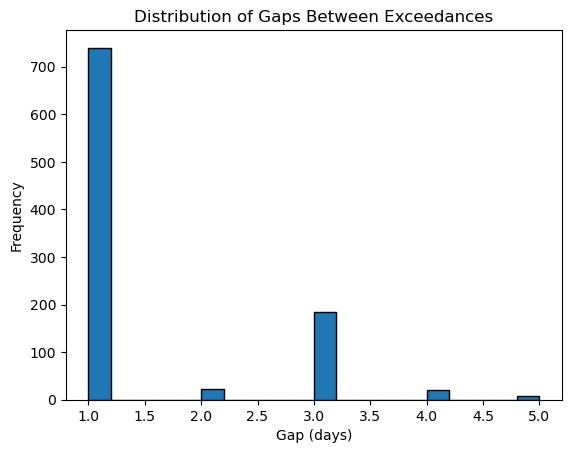

In [61]:
#Let's check the most frequent gaps
plt.hist(exceedances2['Gap'].dropna(), bins=20, edgecolor='black')
plt.title('Distribution of Gaps Between Exceedances')
plt.xlabel('Gap (days)')
plt.ylabel('Frequency')
plt.show()

In [63]:
gap = 1  # Define a gap (days) for de-clustering
exceedances3['Cluster'] = (exceedances3.index.to_series().diff().dt.days > gap).cumsum()

In [64]:
total_exceedances = len(exceedances3)
unique_clusters = exceedances3['Cluster'].nunique()

In [65]:
extremal_index = unique_clusters / total_exceedances
print(f"Extremal Index: {extremal_index}")

Extremal Index: 0.24077868852459017
